Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [1]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/Matandg0/DeepImagePriorBeta
!mv DeepImagePriorBeta/* ./

Cloning into 'DeepImagePriorBeta'...
remote: Enumerating objects: 353, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 353 (delta 36), reused 31 (delta 16), pack-reused 289
Receiving objects: 100% (353/353), 44.16 MiB | 23.60 MiB/s, done.
Resolving deltas: 100% (191/191), done.


# Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

#from skimage.measure import compare_psnr
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 1
#sigma_ = sigma/255.

In [3]:
# deJPEG
# fname = 'data/denoising/snail.jpg'

## denoising
fname = '/kaggle/working/data/denoising/Tour eiffel.jpeg'

# Load image

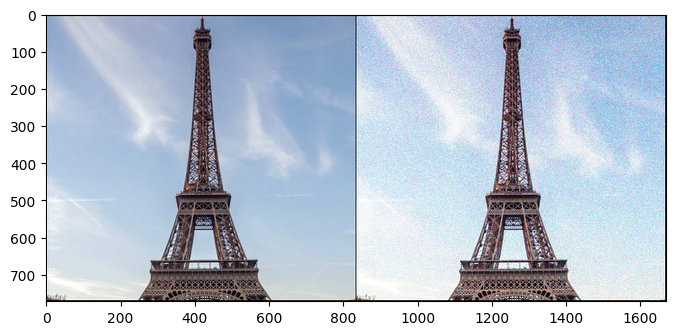

In [4]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)

    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np

    if PLOT:
        plot_image_grid([img_np], 4, 5);

elif fname == '/kaggle/working/data/denoising/Tour eiffel.jpeg':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)

    # Poisson noise
    img_noisy_pil, img_noisy_np = get_noisy_image_poisson(img_np, sigma)

    #Gaussian noise
    # img_noisy_pil, img_noisy_np = get_noisy_image_Gaussian(img_np, intensity)


    #Uniform Noise
    #img_noisy_pil, img_noisy_np = get_noisy_image_uniform(img_np, intensity=0)

    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

# Setup

In [54]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5

    net = skip(
                input_depth, 3,
                num_channels_down = [8, 16, 32, 64, 128],
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4],
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == '/kaggle/working/data/denoising/Tour eiffel.jpeg':
    num_iter = 900
    input_depth = 32
    figsize = 4


    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128,
                  skip_n33u=128,
                  skip_n11=4,
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]);
print ('Number of params: %d' % s)

# Loss Poisson
#Loss = torch.nn.PoissonNLLLoss(log_input=False).type(dtype)

# Loss uniform
#Loss = torch.nn.L1Loss().type(dtype)

#Loss Gaussian
Loss = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2217831


# Optimize

In [55]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0


i = 0
def closure():


    global i, out_avg, psrn_noisy_last, last_net, net_input


    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)


    out = net(net_input)


    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
       out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)


    total_loss = Loss(out, img_noisy_torch)
    total_loss.backward()




    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0])
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0])
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0])


    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    if  PLOT and i % show_every == 0:
        print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r')
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1),
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)






    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint.')


            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())


            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy


    i += 1


    return total_loss


Starting optimization with ADAM
Iteration 00000    Loss 0.150517   PSNR_noisy: 8.224140   PSRN_gt: 10.547096 PSNR_gt_sm: 10.547096 


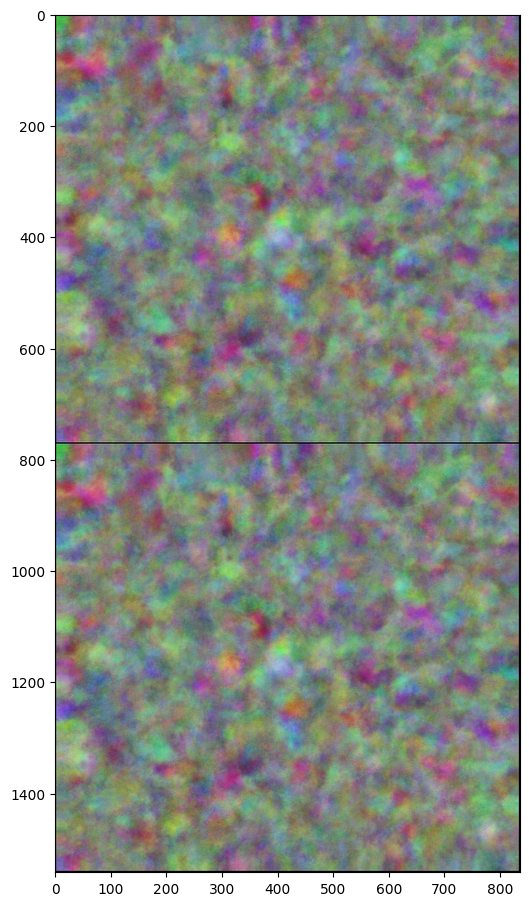

Iteration 00100    Loss 0.017356   PSNR_noisy: 17.605397   PSRN_gt: 18.338168 PSNR_gt_sm: 19.338223 


Iteration 00200    Loss 0.014996   PSNR_noisy: 18.240184   PSRN_gt: 18.643878 PSNR_gt_sm: 21.041152 


Iteration 00300    Loss 0.014171   PSNR_noisy: 18.485917   PSRN_gt: 19.155014 PSNR_gt_sm: 20.105934 


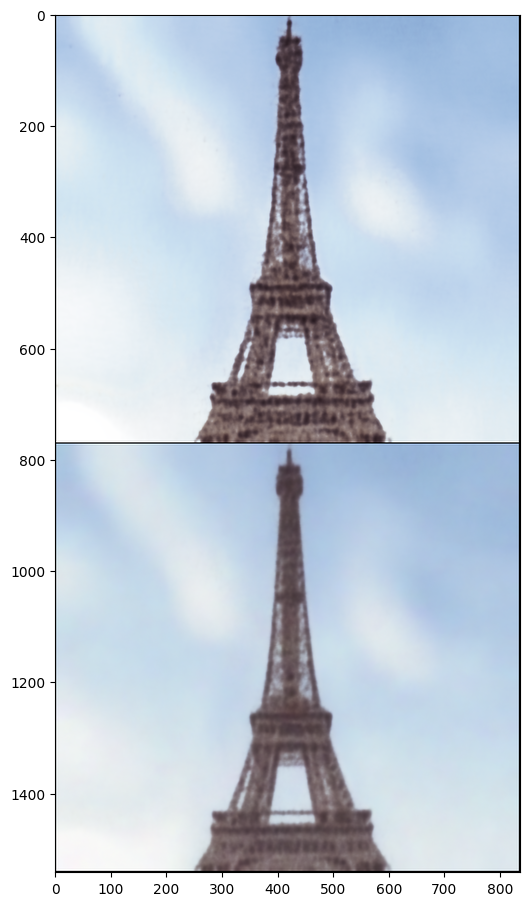

Iteration 00400    Loss 0.013609   PSNR_noisy: 18.661766   PSRN_gt: 19.321498 PSNR_gt_sm: 19.684513 


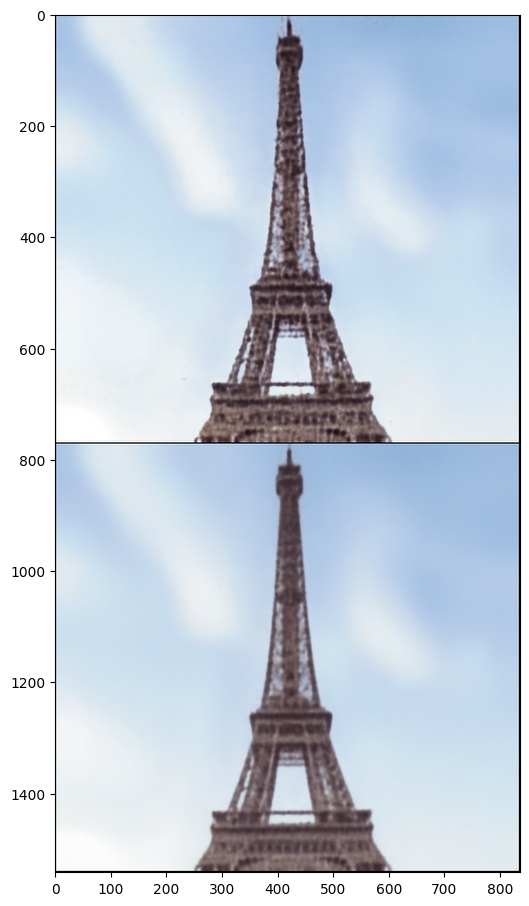

Iteration 00500    Loss 0.013240   PSNR_noisy: 18.781049   PSRN_gt: 19.208421 PSNR_gt_sm: 19.572724 


Iteration 00600    Loss 0.012975   PSNR_noisy: 18.868828   PSRN_gt: 19.388913 PSNR_gt_sm: 19.575578 


Iteration 00700    Loss 0.012741   PSNR_noisy: 18.947841   PSRN_gt: 19.387805 PSNR_gt_sm: 19.614458 


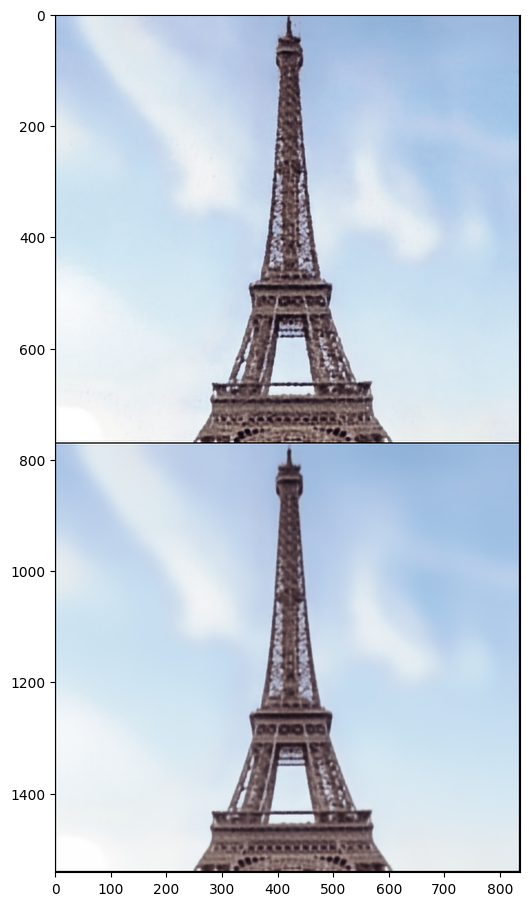

Iteration 00800    Loss 0.012559   PSNR_noisy: 19.010530   PSRN_gt: 19.636431 PSNR_gt_sm: 19.662251 


In [56]:
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)


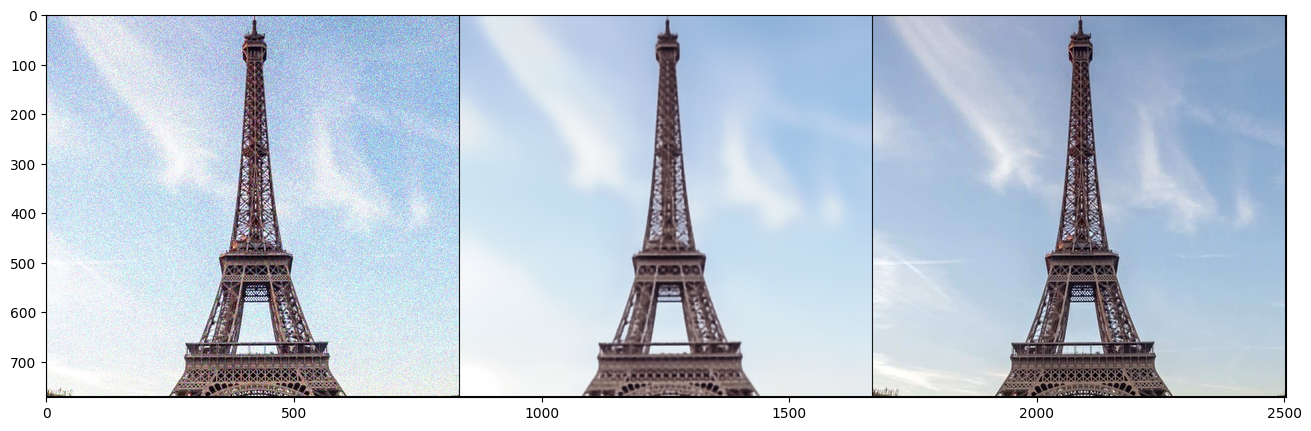

In [57]:
out_np = torch_to_np(net(net_input))
#= torch_to_np(net(net_input))
q = plot_image_grid([img_noisy_np,np.clip(out_np, 0, 1), img_np], factor=13);
q = plot_image_grid([img_noisy_np,np.clip(torch_to_np(out_avg), 0, 1), img_np], factor=13);

In [58]:
out = net(net_input)
psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0])
psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0])
psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0])
print ('PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (psrn_noisy, psrn_gt, psrn_gt_sm), '\r')


PSNR_noisy: 19.101957   PSRN_gt: 19.569065 PSNR_gt_sm: 19.705964 


In [27]:
from skimage.metrics import structural_similarity as ssim

In [60]:
ssim(img_np,out.detach().cpu().numpy()[0],channel_axis=0,data_range=1)

0.91307664

In [61]:
ssim(img_np,out_avg.detach().cpu().numpy()[0],channel_axis=0,data_range=1)

0.92061734

In [63]:
ssim(img_np,img_noisy_np,channel_axis=0,data_range=1)

0.20127846

In [47]:
ssim(img_np,img_np,channel_axis=0,data_range=1)

1.0

In [64]:
import numpy as np
from PIL import Image as PILImage

def np_to_pil(image_np):
    """Converts a numpy array to a PIL Image."""
    return PILImage.fromarray((image_np * 255).astype(np.uint8))

def generate_gaussian_noise(shape, sigma):
    """Generates Gaussian noise.

    Args:
        shape: Shape of the noise array.
        sigma: Standard deviation of the Gaussian distribution.

    Returns:
        numpy.ndarray: Gaussian noise array with values in the range [-1, 1].
    """
    mean=(0,0,0)
    cov = np.array([[sigma*2, sigma*3, sigma],
               [0, sigma*3, sigma*2],
               [0, 0, sigma]])

    # Generate multivariate Gaussian noise
    noise = np.random.multivariate_normal(mean=mean, cov=cov, size=shape)
    return np.clip(np.random.normal(scale=sigma, size=shape), -1, 1)

def generate_uniform_noise(shape, intensity):
    """Generates uniform noise.

    Args:
        shape: Shape of the noise array.
        intensity: Maximum absolute value of the noise.

    Returns:
        numpy.ndarray: Uniform noise array with values in the range [-1, 1].
    """
    return np.clip(np.random.uniform(-intensity, intensity, size=shape), -1, 1)

def generate_poisson_noise(shape, sigma):
    """Generates Poisson noise.

    Args:
        shape: Shape of the noise array.
        sigma: Poisson parameter (mean and variance).

    Returns:
        numpy.ndarray: Poisson noise array with values in the range [-1, 1].
    """
    return np.clip(np.random.poisson(sigma, size=shape) / sigma, -1, 1)

# Example usage:
shape = (512, 512, 3)  # Example shape of the noise array, adjust as needed
sigma = 0.3  # Example standard deviation for Gaussian noise
intensity = 0.5  # Example intensity for uniform noise
poisson_param = 0.1  # Example Poisson parameter
gaussian_noise = generate_gaussian_noise(shape, sigma)
uniform_noise = generate_uniform_noise(shape, intensity)
poisson_noise = generate_poisson_noise(shape, poisson_param)

# Convert noise arrays to PIL Images if needed
gaussian_noise_img = np_to_pil((gaussian_noise + 1) / 2)  # Converting to [0, 1] range for display
uniform_noise_img = np_to_pil((uniform_noise + 1) / 2)  # Converting to [0, 1] range for display
poisson_noise_img = np_to_pil((poisson_noise + 1) / 2)  # Converting to [0, 1] range for display


/tmp/ipykernel_34/2981631261.py:24: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise = np.random.multivariate_normal(mean=mean, cov=cov, size=shape)


In [65]:
import matplotlib.pyplot as plt

def show_image(image, title=''):
    """Display the given image."""
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display Gaussian noise image
show_image(gaussian_noise_img, title='Gaussian Noise')

# Display Uniform noise image
show_image(uniform_noise_img, title='Uniform Noise')

# Display Poisson noise image
show_image(poisson_noise_img, title='Poisson Noise')
